In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

/opt/anaconda3/envs/tf-1.10/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/tf-1.10/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/tf-1.10/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/tf-1.10/lib/python3.6/site-packages/tensorflow/

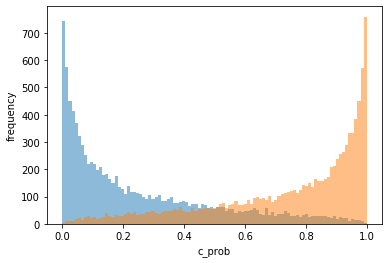

x has shape (20000, 30) 

coefficient values:
-0.0    11
-0.4     8
 0.4     5
 0.8     3
-0.8     2
 1.2     1
dtype: int64 

c has shape (20000,) 

c values
1    10054
0     9946
dtype: int64 



In [2]:
# simulate condition c as a function of covariates x

n_features = 30
n_examples = 20000

x = np.random.randn(n_examples, n_features)
xc_coeffs = .4 * np.round(np.random.randn(n_features))
c_logits = np.squeeze(x @ xc_coeffs[:, np.newaxis])

def logistic(x): return 1 / (1 + np.exp(-1 * x))

c_prob = logistic(c_logits)
c = (np.random.rand(n_examples) < c_prob).astype(int)

plt.hist(c_prob[c == 0], bins=np.linspace(0, 1, 100), alpha=.5)
plt.hist(c_prob[c == 1], bins=np.linspace(0, 1, 100), alpha=.5)
plt.xlabel('c_prob')
plt.ylabel('frequency')
plt.show()

print('x has shape', np.shape(x), '\n')
print('coefficient values:')
print(pd.value_counts(xc_coeffs), '\n')
print('c has shape', np.shape(c), '\n')
print('c values')
print(pd.value_counts(c), '\n')

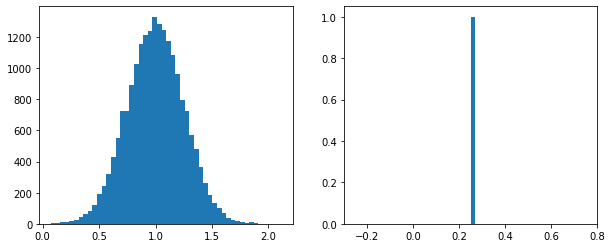

In [3]:
# simulate event times as a function of c and x with uniform censoring

max_time = 10

xmu_coeffs = .05 * np.round(np.random.randn(n_features))
mu_event = np.squeeze(1 + (x @ xmu_coeffs[:, np.newaxis]))

#xsigsq_coeffs = .02 * np.round(np.random.randn(n_features))
#sigsq_event = np.squeeze(x @ xsigsq_coeffs[:, np.newaxis])

sigsq_event = .25

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(mu_event, bins=50)
ax[1].hist(sigsq_event, bins=50)
plt.show()

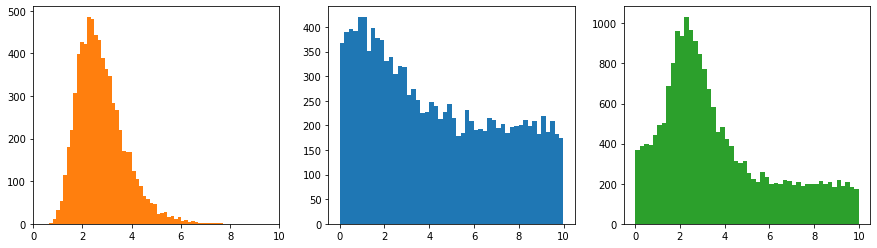

In [4]:
event_times = np.exp(mu_event + sigsq_event * np.random.randn(n_examples)) + max_time * (1 - c)
censoring_times = max_time * np.random.rand(n_examples)

t = np.minimum(event_times, censoring_times)
s = (t == event_times).astype(int)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].hist(t[s == 1], color='C1', bins=50)
ax[0].set_xlim([0, 10])
ax[1].hist(t[s == 0], color='C0', bins=50)
ax[2].hist(t, color='C2', bins=50)
plt.show()

In [5]:
import sys
sys.path.append('../src')
from model import CFTModel

In [6]:
mdl = CFTModel()
with tf.Session() as sess:
    mdl.train(sess, x, t[:, np.newaxis], s[:, np.newaxis], 200, learning_rate=1e-3)
    c_pred = mdl.predict_c(sess, x)
    c_weights = mdl.get_c_weights(sess)
    t_pred = mdl.predict_t(sess, x)

Initial Values:
nloglik = 3.52e+00
t_mu: 3.68e-03 t_logvar: -1.22e-02

Completed Epoch 0
nloglik = 2.57e+00
t_mu: 6.06e-02 t_logvar: 4.69e-02

Completed Epoch 10
nloglik = 1.37e+00
t_mu: 4.95e-01 t_logvar: 2.33e-01

Completed Epoch 20
nloglik = 1.09e+00
t_mu: 9.11e-01 t_logvar: 1.36e-01

Completed Epoch 30
nloglik = 9.37e-01
t_mu: 1.25e+00 t_logvar: -9.06e-02

Completed Epoch 40
nloglik = 8.95e-01
t_mu: 1.40e+00 t_logvar: -2.91e-01

Completed Epoch 50
nloglik = 8.77e-01
t_mu: 1.46e+00 t_logvar: -4.70e-01

Completed Epoch 60
nloglik = 8.68e-01
t_mu: 1.48e+00 t_logvar: -6.19e-01

Completed Epoch 70
nloglik = 8.64e-01
t_mu: 1.50e+00 t_logvar: -7.16e-01

Completed Epoch 80
nloglik = 8.61e-01
t_mu: 1.50e+00 t_logvar: -7.62e-01

Completed Epoch 90
nloglik = 8.59e-01
t_mu: 1.50e+00 t_logvar: -7.76e-01

Completed Epoch 100
nloglik = 8.58e-01
t_mu: 1.51e+00 t_logvar: -7.77e-01

Completed Epoch 110
nloglik = 8.58e-01
t_mu: 1.51e+00 t_logvar: -7.76e-01

Completed Epoch 120
nloglik = 8.57e-01
t_mu

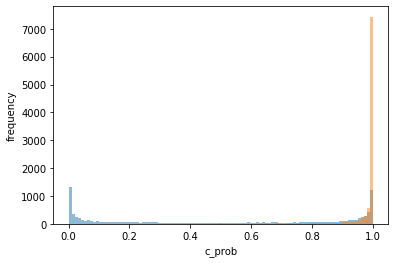

In [7]:
plt.hist(c_pred[c == 0], bins=np.linspace(0, 1, 100), alpha=.5)
plt.hist(c_pred[c == 1], bins=np.linspace(0, 1, 100), alpha=.5)
plt.xlabel('c_prob')
plt.ylabel('frequency')
plt.show()

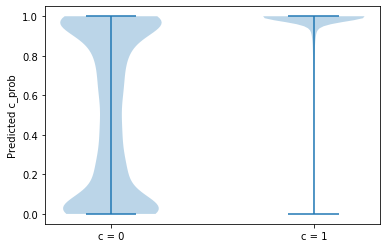

In [8]:
plt.violinplot([c_pred[c == 0], c_pred[c == 1]])
plt.xticks([1, 2], ['c = 0', 'c = 1'])
plt.ylabel('Predicted c_prob')
plt.show()

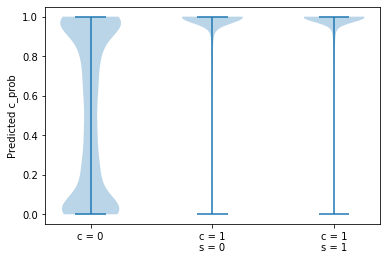

In [9]:
plt.violinplot([c_pred[c == 0], c_pred[(c == 1) & (s == 0)], c_pred[(c == 1) & (s == 1)]])
plt.xticks([1, 2, 3], ['c = 0', 'c = 1\ns = 0', 'c = 1\ns = 1'])
plt.ylabel('Predicted c_prob')
plt.show()

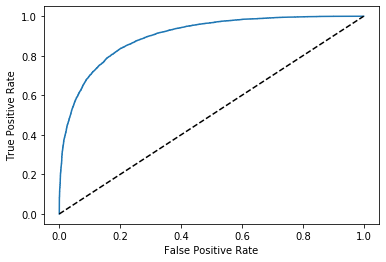

AUC = 0.90
Optimal AUC = 0.90


In [10]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(c, c_pred)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

print('AUC = %.2f' % roc_auc_score(c, c_pred))
print('Optimal AUC = %.2f' % roc_auc_score(c, c_prob))

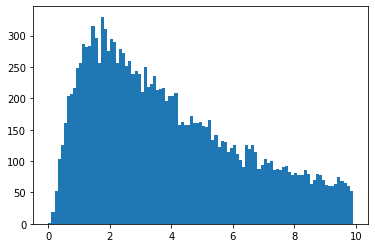

In [11]:
plt.hist(t_pred, bins=np.arange(100) / 10)
plt.show()

# Issues

- nature of penalty. is there a more principled way to choose this?
- when using NN, it will predict everyone is positive (to avoid penalty, presumably)
- dealing with variance of lognormal distribution

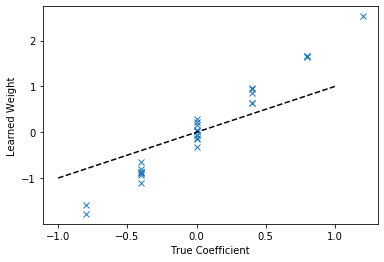

In [12]:
plt.plot(xc_coeffs, c_weights, 'x')
plt.plot([-1, 1], [-1, 1], 'k--')
plt.xlabel('True Coefficient')
plt.ylabel('Learned Weight')
plt.show()

We know what the optimal AUC is: comes from the Bernoulli. Need to state this.

- check the logpdf

- go back to AFT model -- will show how to treat variance?
- for variational autoencoder will show you how they handle the variance
- figure out what's wrong with the loss going nan
- go back to the model. how do we define penalty?
- add some form of regularization, e.g. noise, dropout, direct penalty
- implement the ARM